<h1><center>Autoencoder on MNIST using Keras<center></h1>
<h3><center>Adrien Boitreaud<center></h3>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA

## Importing Keras

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.7.0
Using keras version 2.7.0


## Loading and preparing the MNIST dataset

Load the MNIST dataset via keras.datasets. Again, turn train and test labels into one-hot encoding, and reshape and normalize data as in the first exercise. 

In [3]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
# START CODE HERE
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
print(f'There are {train_data[0].shape[0]} images in the train set')
print(f'There are {test_data[0].shape[0]} images in the test set')
# END CODE HERE

There are 60000 images in the train set
There are 10000 images in the test set


In [4]:
#Load images and labels
train_images = train_data[0]
test_images = test_data[0]
y_train = train_data[1]
y_test = test_data[1]

In [5]:
# Do you remember about one-hot encoding ?
from keras.utils.np_utils import to_categorical
# START CODE HERE
train_samples = y_train.shape[0]
test_samples = y_test.shape[0]
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_train_onehot = tf.constant(y_train_onehot, shape=[train_samples, 10])

y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_test_onehot = tf.constant(y_test_onehot, shape=[test_samples, 10])
# END CODE HERE

In [6]:
# Reshape to proper images with 1 color channel according to backend scheme
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
# START CODE HERE
x_train = train_images.reshape(-1,784).astype('float32')
x_test = test_images.reshape(-1,784).astype('float32')
# END CODE HERE

# Cast pixels from uint8 to float32
# train_images = train_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
# START CODE HERE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# END CODE HERE

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:

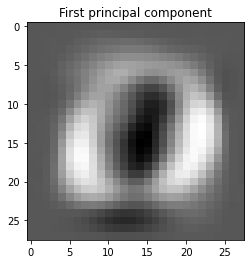

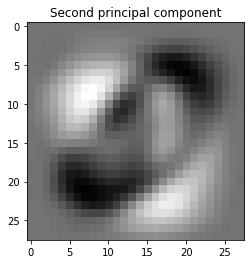

In [7]:
# Let's find the first 2 PCA components
num_components = 2
# START CODE HERE
pca = PCA(n_components= num_components)
pca.fit(x_train)
components = pca.components_
# END CODE HERE

# Reshape so they resemble images and we can print them
# START CODE HERE
components = components.reshape(2,28,28)
# END CODE HERE

# Show the reshaped principal components
# START CODE HERE
plt.imshow(components[0], cmap='gray')
plt.title('First principal component')
plt.show()
plt.imshow(components[1], cmap='gray')
plt.title('Second principal component')
plt.show()
# END CODE HERE

In [8]:
# Print the variance explained by those components
var = pca.explained_variance_
print(f'The first principal component explains {var[0]:.1f}% of the variance\n')
print(f'The second principal component explains {var[1]:.1f}% of the variance\n')
print(f'With these two components, {np.sum(var):.1f}% of the variance is explained')

The first principal component explains 40.5% of the variance

The second principal component explains 29.2% of the variance

With these two components, 69.7% of the variance is explained


**Comment on the visualization in relation to the variance explained by only keeping the two principal components.**

>With the Standard Scaler, the two images are not very easy to analyse and comment, but the PCA gives a good ratio of explained variance.\
If we use another method to preprocess data, like just dividing by 255 to bring back all values between 0 and 1, the obtained images are more self explanatory, but the variance explaned is much smaller.

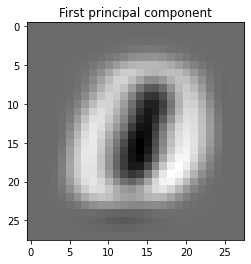

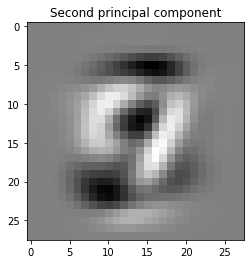

With Normalizer:
The first principal component explains 5.1% of the variance

The second principal component explains 3.7% of the variance

With these two components, 8.9% of the variance is explained


In [9]:
x_train = train_images.reshape(-1,784).astype('float32')/255.0
x_test = test_images.reshape(-1,784).astype('float32')/255.0

num_components = 2
pca = PCA(n_components= num_components)
pca.fit(x_train)
components = pca.components_

# Reshape so they resemble images and we can print them
components = components.reshape(2,28,28)

# Show the reshaped principal components
# START CODE HERE
plt.imshow(components[0], cmap='gray')
plt.title('First principal component')
plt.show()
plt.imshow(components[1], cmap='gray')
plt.title('Second principal component')
plt.show()
var = pca.explained_variance_
print('With Normalizer:')
print(f'The first principal component explains {var[0]:.1f}% of the variance\n')
print(f'The second principal component explains {var[1]:.1f}% of the variance\n')
print(f'With these two components, {np.sum(var):.1f}% of the variance is explained')

Here, the two images look like to be a zero and a nine.

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

In [11]:
# Input layer
input_layer = Input(shape=(784,), name ='input' )

In [12]:
# Encoding layer
latent_view = Dense(2)(input_layer)

In [13]:
# Decoding layer
output_layer = Dense(784, activation='sigmoid', name='output_layer')(latent_view)

In [14]:
ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
 output_layer (Dense)        (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples.  

>With an auto-encoder, we should use mean squarred error as loss function, which is what is called sum of squared differences is the course.

In [15]:
from tensorflow.keras.losses import MeanSquaredError
loss = 'mean_squared_error'

optimizer = SGD(learning_rate=0.1)
ae_model.compile(optimizer=optimizer, loss=MeanSquaredError()) 

In [16]:
batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(x_train,
                       x_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(x_test, x_test))

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.2300 - val_loss: 0.2285
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.2236 - val_loss: 0.2124
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.1698 - val_loss: 0.1156
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0918 - val_loss: 0.0793
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0763 - val_loss: 0.0742
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0733 - val_loss: 0.0726
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0722 - val_loss: 0.0718
Epoch 8/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0715 - val_loss: 0.0713
Epoch 9/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0711 - val_loss: 0.0710
Epoch 10/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0708 - val_loss: 0.0707

>It's quite annoying to see that the loss cannot be reduced further than this. From epoch 5, it stops improving.

Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

In [17]:
latent_weights, _ = ae_model.get_layer('dense').get_weights()

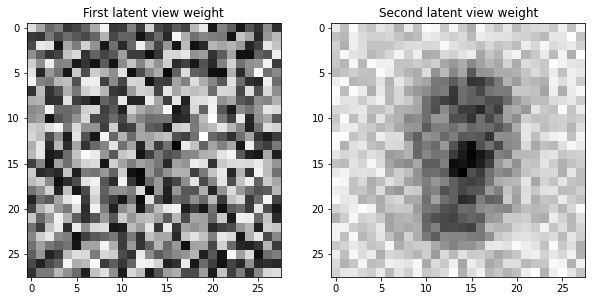

In [18]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)
# START CODE HERE
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(latent_weights[:,0].reshape(28,28), cmap='gray')
ax[0].set_title('First latent view weight')
ax[1].imshow(latent_weights[:,1].reshape(28,28), cmap='gray')
ax[1].set_title('Second latent view weight')
plt.show()
# END CODE HERE

>We can see a nine appearing on the second weight. This could probably be better and closer to what we had with the PCA if the loss was further reduced and the training more efficient.

Now, visualize the images rebuild by the network !

In [19]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

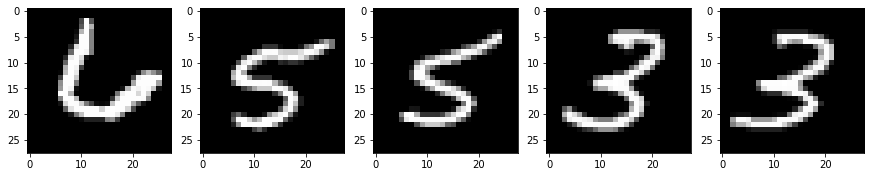

In [20]:
# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(15,15))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape(28,28),cmap='gray')

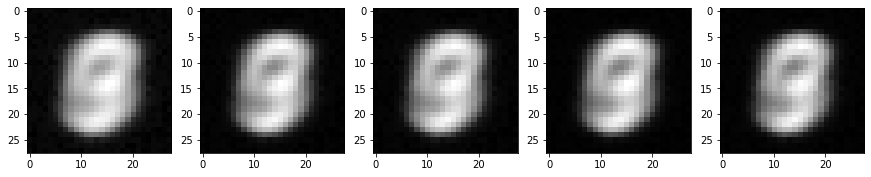

In [21]:
# Get the prediction from the model
ae_images = ae_model.predict(x_test)

# And plot them
f, ax = plt.subplots(1,5, figsize=(15,15))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(ae_images[a].reshape(28,28),cmap='gray')

>This poor rendering shows that the model is not efficiently trained at all. This confirms the issue I have optimizing the loss function.\
It's quite disappointing to see that the model sort of always renders the same image, whatever the input is.

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 

In [22]:
# START CODE HERE
# Input layer
input_layer = Input(shape=(784,), name ='input' )

# Encoding layer
latent_view = Dense(32, name='dense_128')(input_layer)

# Decoding layer
output_layer = Dense(784, activation='sigmoid', name='output_layer_128')(latent_view)

ae_model_128 = Model(input_layer, output_layer, name='ae_model_128')
ae_model_128.summary()
# END CODE HERE

Model: "ae_model_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 dense_128 (Dense)           (None, 32)                25120     
                                                                 
 output_layer_128 (Dense)    (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [23]:
optimizer = SGD(learning_rate=1e-1) 
ae_model_128.compile(optimizer='adam', loss=loss)

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model_128.fit(x_train,
                       x_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(x_test, x_test))

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0530 - val_loss: 0.0312
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0254 - val_loss: 0.0204
Epoch 3/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0180 - val_loss: 0.0154
Epoch 4/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0142 - val_loss: 0.0125
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0120 - val_loss: 0.0110
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 9/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 10/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0101 - val_loss: 0.0097

>Here I've tried with adam optimizer. It seems to go further in the loss minimization but still get stuck at a certain value from some epoch on.

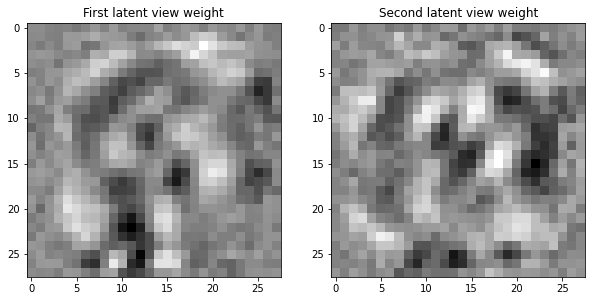

In [24]:
latent_weights, _ = ae_model_128.get_layer('dense_128').get_weights()
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(latent_weights[:,0].reshape(28,28), cmap='gray')
ax[0].set_title('First latent view weight')
ax[1].imshow(latent_weights[:,1].reshape(28,28), cmap='gray')
ax[1].set_title('Second latent view weight')
plt.show()
# END CODE HERE

In [25]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

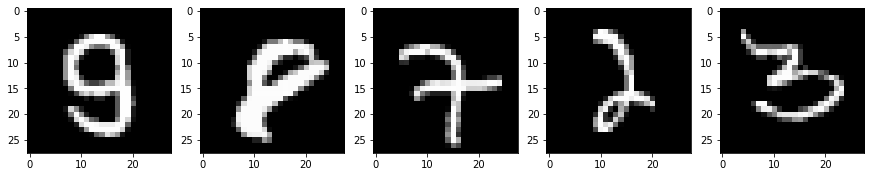

In [26]:
# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(15,15))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape(28,28),cmap='gray')

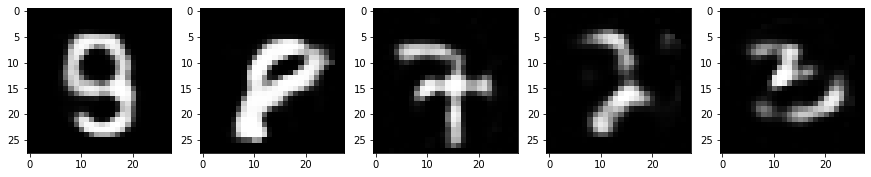

In [27]:
# Get the prediction from the model
ae_images = ae_model_128.predict(x_test)

# And plot them
f, ax = plt.subplots(1,5, figsize=(15,15))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(ae_images[a].reshape(28,28),cmap='gray')

>The rendered images are already better with this optimizer and a greater dimension of the latent space. The digits are recognizable and the images are close to the initial ones.

## Denoising auto-encoder 

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built. 

In [28]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.3
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [29]:
# Create a copy of the data with added noise
noisy_train_images = noise(x_train)
noisy_test_images = noise(x_test)

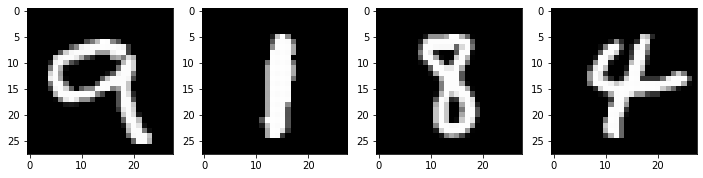

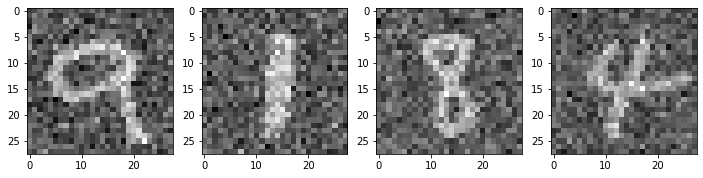

In [30]:
# Visualize some of the images with noise against the originals
# START CODE HERE
random_idx = np.random.randint(0,len(train_images)-4) 
f, ax = plt.subplots(1, 4, figsize=(12,12))
for i,a in enumerate(range(random_idx, random_idx + 4)):
    ax[i].imshow(x_train[a].reshape(28,28),cmap='gray')
    
f, ax = plt.subplots(1, 4, figsize=(12,12))
for i,a in enumerate(range(random_idx, random_idx + 4)):
    ax[i].imshow(noisy_train_images[a].reshape(28,28),cmap='gray')
# END CODE HERE

In [31]:
# Build a new model with more layers and Relu activations
# START CODE HERE
# Input layer
input_layer = Input(shape=(784,), name ='input' )

# Encoding layer
latent_view1 = Dense(64, activation='relu', name='dense1_64')(input_layer)
latent_view2 = Dense(64, activation='relu', name='dense2_64')(latent_view1)
latent_view3 = Dense(64, activation='relu', name='dense3_64')(latent_view2)
latent_view4 = Dense(64, activation='relu', name='dense4_64')(latent_view3)

# Decoding layer
output_layer = Dense(784, activation='sigmoid', name='output_layer_64')(latent_view4)

ae_model_64 = Model(input_layer, output_layer, name='ae_model_64')
ae_model_64.summary()
# END CODE HERE

Model: "ae_model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 dense1_64 (Dense)           (None, 64)                50240     
                                                                 
 dense2_64 (Dense)           (None, 64)                4160      
                                                                 
 dense3_64 (Dense)           (None, 64)                4160      
                                                                 
 dense4_64 (Dense)           (None, 64)                4160      
                                                                 
 output_layer_64 (Dense)     (None, 784)               50960     
                                                                 
Total params: 113,680
Trainable params: 113,680
Non-tra

In [32]:
# Compile it but here, use noised data as inputs !
# START CODE HERE
optimizer = SGD(learning_rate=1e-1) 
ae_model_64.compile(optimizer='adam', loss=loss)

batch_size = 128
epochs = 10
history = ae_model_64.fit(noisy_train_images,
                       noisy_train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(noisy_test_images, noisy_test_images))
# END CODE HERE

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1407 - val_loss: 0.1175
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1133 - val_loss: 0.1098
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1080 - val_loss: 0.1057
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1049 - val_loss: 0.1035
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1031 - val_loss: 0.1022
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1019 - val_loss: 0.1012
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1009 - val_loss: 0.1004
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1002 - val_loss: 0.0997
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0996 - val_loss: 0.0994
Epoch 10/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0992 - val_loss: 0.0989

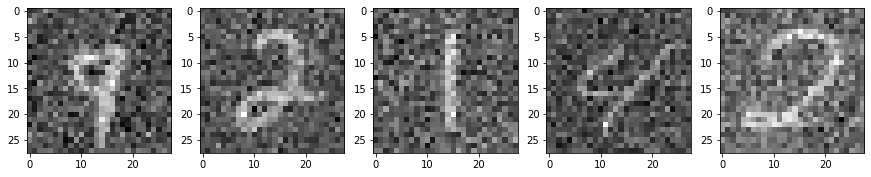

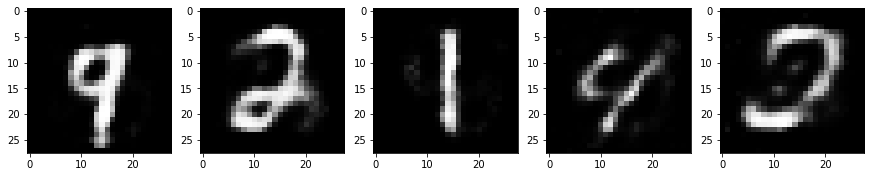

In [33]:
# Visualize the images rebuilt by the model !
# START CODE HERE
n = np.random.randint(0,len(test_images)-5)
# END CODE HERE
f, ax = plt.subplots(1,5, figsize=(15,15))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(noisy_test_images[a].reshape(28,28),cmap='gray')
    
# Get the prediction from the model
ae_images = ae_model_64.predict(noisy_test_images)

# And plot them
f, ax = plt.subplots(1,5, figsize=(15,15))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(ae_images[a].reshape(28,28),cmap='gray')

>Even though the loss minimizing phase was still not very good, since we got stuck with a loss a 0.1 approx., we can see that the image are quite well denoised.

**Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?**

>With such a normalization, we can also use the softmax function, wich is implemented as Categorical Cross Entropy in Keras